## Domestic COVID Data Exploration 

In this notebook, we explore U.S. COVID data from various sources. Our primary goal is to see if there are differences between states that had a vaccine mandate and those that did not.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# JHU Data Import

df_vacc_up = pd.read_csv("../../data/jhu/people_vaccinated_us_timeline.csv")
df_vacc_up.rename(columns={"Province_State": "Location"}, inplace=True)

In [3]:
# KFF Data Import

df_vacc_man = pd.read_csv(
    "../../data/kff/vaccine_mandates.csv", skiprows=[0, 1, 3, 55, 56, 57, 58]
)

In [4]:
# Census Data Import

df_total_pop = (
    pd.read_csv("../../data/census/total_population.csv", skiprows=[1])
    .transpose()
    .reset_index()
)
df_total_pop.columns = df_total_pop.iloc[0]
df_total_pop.drop(df_total_pop.index[0], inplace=True)
df_total_pop.rename(columns={"Unnamed: 0": "Location"}, inplace=True)
df_total_pop.replace(
    [
        ",",
    ],
    "",
    regex=True,
    inplace=True,
)

### Dictionary

In [5]:
# Dictionary for mandates

mandate = {
    "state": [
        "Oregon",
        "California",
        "Nevada",
        "Colorado",
        "New Mexico",
        "Minnesota",
        "New York",
        "New Jersey",
        "Delaware",
        "North Carolina",
        "Hawaii",
    ],
    "healthcare": [
        "Washington",
        "Oregon",
        "California",
        "Nevada",
        "Colorado",
        "New Mexico",
        "Illinois",
        "Maine",
        "New York",
        "Rhode Island",
        "New Jersey",
        "Delaware",
        "Maryland",
    ],
    "school": [
        "Washington",
        "Oregon",
        "California",
        "New Mexico",
        "Illinois",
        "New York",
        "Connecticut",
        "New Jersey",
        "Delaware",
        "Hawaii",
    ],
}

In [6]:
# Dictionary for number of mandates

three_mandates = [
    "Oregon",
    "California",
    "New York",
    "Delaware",
    "New Mexico",
    "New Jersey",
]
two_mandates = ["Washington", "Colorado", "Nevada", "Hawaii", "Illinois"]
one_mandate = [
    "Connecticut",
    "Maryland",
    "Rhode Island",
    "Maine",
    "North Carolina",
    "Minnesota",
]

#### Binary Mandate Analysis

In [7]:
vacc_final = df_vacc_up.merge(
    df_vacc_man[["Location", "Any Mandate in Place?"]], on="Location"
).merge(df_total_pop, on="Location")

In [8]:
vacc_final["Total"] = vacc_final["Total"].apply(pd.to_numeric)

In [9]:
vacc_final.loc[:, ["People_Fully_Vaccinated", "People_Partially_Vaccinated"]] = (
    vacc_final.loc[:, ["People_Fully_Vaccinated", "People_Partially_Vaccinated"]]
    .div(vacc_final.loc[:, "Total"], axis=0)
    .multiply(100)
)

In [10]:
# Assign a new column dependent on how many mandates each state had


def label_mandate(row):
    if row["Location"] in three_mandates:
        return "3 Mandates"
    elif row["Location"] in two_mandates:
        return "2 Mandates"
    elif row["Location"] in one_mandate:
        return "1 Mandate"
    return "None"


vacc_final["How Many Mandates?"] = vacc_final.apply(
    lambda row: label_mandate(row), axis=1
)

In [11]:
# Pre-plot work to make graph prettier and df easier to work with

vacc_final["Month"] = pd.DatetimeIndex(vacc_final["Date"]).month
vacc_final["Year"] = pd.DatetimeIndex(vacc_final["Date"]).year

vacc_final["Month"] = vacc_final["Month"].replace(
    {
        1: "Jan",
        2: "Feb",
        3: "March",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec",
    }
)

vacc_final["Time"] = (
    vacc_final["Month"].astype(str) + " " + vacc_final["Year"].astype(str)
)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

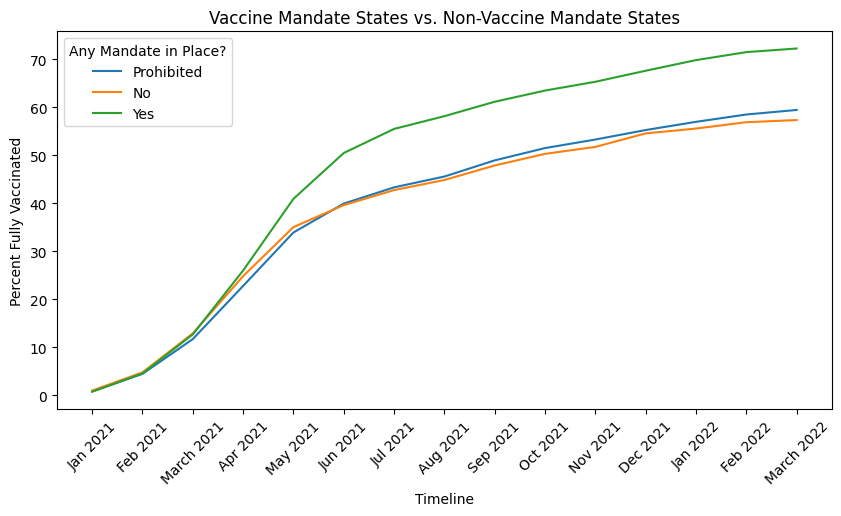

In [16]:
# JHU Vaccine Rates (based on Census 2019 Population) Plot

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

sns.lineplot(
    data=vacc_final,
    x="Time",
    y="People_Fully_Vaccinated",
    hue="Any Mandate in Place?",
    ci=None,
)

ax.set(xlabel="Timeline", ylabel="Percent Fully Vaccinated")
ax.set(title="Vaccine Mandate States vs. Non-Vaccine Mandate States")
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

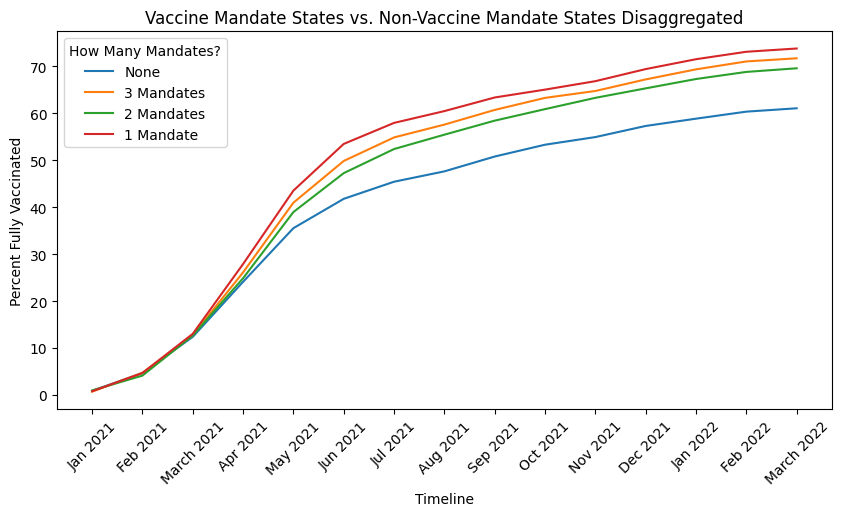

In [17]:
# JHU Vaccine Rates (based on Census 2019 Population) Dependent on Number of Mandates

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

sns.lineplot(
    data=vacc_final,
    x="Time",
    y="People_Fully_Vaccinated",
    hue="How Many Mandates?",
    ci=None,
)

ax.set(xlabel="Timeline", ylabel="Percent Fully Vaccinated")
ax.set(title="Vaccine Mandate States vs. Non-Vaccine Mandate States Disaggregated")
plt.xticks(rotation=45)